In [189]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [283]:
tab=pd.read_csv('ridesSeries2.csv',sep=',')

In [328]:
tab.loc[397]

date1            2018-02-02
boarded_rides         23647
Name: 397, dtype: object

In [311]:
baseTrain=tab.loc[:396]
#len(baseTrain)

In [312]:
baseTrain

,date1,boarded_rides
0,2017-01-01,23774
1,2017-01-02,17676
2,2017-01-03,18363
3,2017-01-04,18756
4,2017-01-05,20153
5,2017-01-06,20923
6,2017-01-07,20186
7,2017-01-08,17622
8,2017-01-09,15444
9,2017-01-10,21353


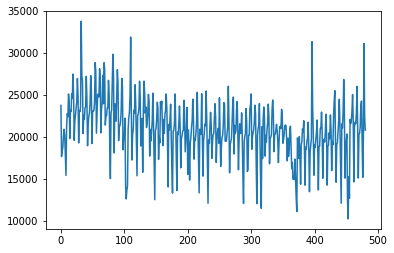

In [313]:
plt.plot(tab['boarded_rides'])
plt.show()

# creating the model

In [314]:
tf.reset_default_graph()

# constants

In [316]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 396

# Placeholders

In [317]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# RNN cell layer

In [318]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

### Dynamic RNN cell

In [319]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [320]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

### init variables

In [321]:
init = tf.global_variables_initializer()

## Session

In [322]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [323]:
saver = tf.train.Saver()

In [324]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        #X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        X_batch, y_batch = baseTrain.iloc[:-1,1].values.reshape(-1,num_time_steps, 1),baseTrain.iloc[1:,1].values.reshape(-1, num_time_steps, 1) 
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 686873300.0
100 	MSE: 34697616.0
200 	MSE: 17572378.0
300 	MSE: 13587484.0
400 	MSE: 11866526.0
500 	MSE: 11319888.0
600 	MSE: 10772715.0
700 	MSE: 10151529.0
800 	MSE: 9475588.0
900 	MSE: 8537411.0
1000 	MSE: 7036773.0
1100 	MSE: 6153110.0
1200 	MSE: 5467831.5
1300 	MSE: 4674281.5
1400 	MSE: 4354431.5
1500 	MSE: 4171246.5
1600 	MSE: 4047101.5
1700 	MSE: 3949267.8
1800 	MSE: 3857410.5
1900 	MSE: 3773484.0


### Predicting a time series t+1

In [325]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = baseTrain.iloc[:-1,1].values.reshape(-1,num_time_steps, 1)
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


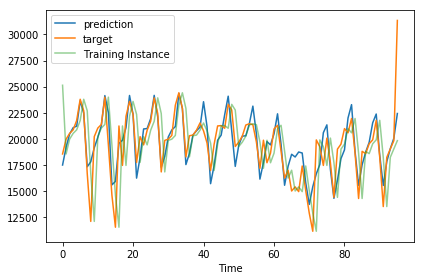

In [398]:

#plt.plot(tab.loc[424:] , y_pred[0,:44,0], "r.", markersize=10, label="prediction")
#y_pred[0,:,0]
#X_new[0,:,0]
#y_pred[0,:,0]
#len(tab.loc[424:])
#y_pred[0,:44,0]

#print(tab.loc[424:])

plt.plot(y_pred[0,:,0][300:396], markersize=10, label="prediction")
plt.plot(baseTrain.iloc[1:,1].values.reshape(-1,num_time_steps, 1)[0][300:396], markersize=10, label="target")
plt.plot(baseTrain.iloc[:-1,1].values.reshape(-1,num_time_steps, 1)[0][300:396],markersize=15,alpha=0.5, label="Training Instance")
#plt.show()

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequences
** Note: Can give wacky results sometimes, like exponential growth**

In [434]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(baseTrain.iloc[:396,1])
    #list(ts_data.y_true[:30])
    for iteration in range(90):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


In [435]:
training_instance

[23774,
 17676,
 18363,
 18756,
 20153,
 20923,
 20186,
 17622,
 15444,
 21353,
 22776,
 22429,
 25117,
 24190,
 19827,
 23196,
 23030,
 25139,
 24618,
 27503,
 24882,
 19618,
 21991,
 22654,
 23543,
 24218,
 26973,
 24859,
 19305,
 23138,
 23023,
 23662,
 33779,
 27293,
 26667,
 20418,
 22656,
 22125,
 23472,
 23606,
 27231,
 24521,
 18969,
 21492,
 22466,
 22862,
 24033,
 27311,
 25597,
 19235,
 23083,
 23074,
 23172,
 24111,
 28853,
 27837,
 20462,
 22651,
 25103,
 24923,
 24769,
 28135,
 26907,
 20499,
 23281,
 24042,
 27348,
 23959,
 28846,
 28099,
 21430,
 22436,
 22568,
 23478,
 23486,
 26747,
 25256,
 19218,
 15059,
 22871,
 23197,
 26724,
 29852,
 27046,
 18115,
 23964,
 22640,
 21893,
 24754,
 28015,
 26485,
 19575,
 21313,
 21298,
 21827,
 23056,
 26984,
 26035,
 18488,
 20117,
 20147,
 22249,
 14307,
 12633,
 13688,
 14172,
 20891,
 22267,
 22912,
 24987,
 31904,
 23060,
 17266,
 20226,
 20875,
 23198,
 22839,
 26226,
 23850,
 19473,
 15394,
 22490,
 22769,
 23410,
 26649,


In [443]:
training_instance

[23774,
 17676,
 18363,
 18756,
 20153,
 20923,
 20186,
 17622,
 15444,
 21353,
 22776,
 22429,
 25117,
 24190,
 19827,
 23196,
 23030,
 25139,
 24618,
 27503,
 24882,
 19618,
 21991,
 22654,
 23543,
 24218,
 26973,
 24859,
 19305,
 23138,
 23023,
 23662,
 33779,
 27293,
 26667,
 20418,
 22656,
 22125,
 23472,
 23606,
 27231,
 24521,
 18969,
 21492,
 22466,
 22862,
 24033,
 27311,
 25597,
 19235,
 23083,
 23074,
 23172,
 24111,
 28853,
 27837,
 20462,
 22651,
 25103,
 24923,
 24769,
 28135,
 26907,
 20499,
 23281,
 24042,
 27348,
 23959,
 28846,
 28099,
 21430,
 22436,
 22568,
 23478,
 23486,
 26747,
 25256,
 19218,
 15059,
 22871,
 23197,
 26724,
 29852,
 27046,
 18115,
 23964,
 22640,
 21893,
 24754,
 28015,
 26485,
 19575,
 21313,
 21298,
 21827,
 23056,
 26984,
 26035,
 18488,
 20117,
 20147,
 22249,
 14307,
 12633,
 13688,
 14172,
 20891,
 22267,
 22912,
 24987,
 31904,
 23060,
 17266,
 20226,
 20875,
 23198,
 22839,
 26226,
 23850,
 19473,
 15394,
 22490,
 22769,
 23410,
 26649,


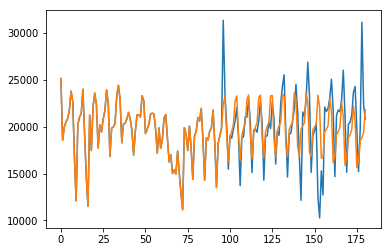

In [449]:
plt.plot(list(tab['boarded_rides'])[300:481])
plt.plot(training_instance[300:481], label="prediction")
plt.show()

 

In [448]:
len(tab)

481